In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [139]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, state):
        x = torch.relu(self.input_layer(state))
        action_probs = self.softmax(self.output_layer(x))
        return action_probs

# Utility function to compute policy loss
def compute_policy_loss(log_probs, rewards):
    return -torch.sum(log_probs * rewards)

# Function to collect trajectories and calculate total reward
def collect_trajectories(env, policy_net, batch_size):
    trajectories = []
    total_rewards = []
    for _ in range(batch_size):
        state, _ = env.reset()
        episode = []
        total_reward = 0
        done = False
        while not done:
            # Convert state to a tensor and get action probabilities
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = policy_net(state_tensor).detach()

            # Use torch.multinomial to sample an action
            action = torch.multinomial(action_probs, num_samples=1).item()

            # Step in the environment
            next_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc

            # Store the transition and accumulate rewards
            episode.append((state, action, reward))
            total_reward += reward
            state = next_state
        
        trajectories.append(episode)
        total_rewards.append(total_reward)
    
    return trajectories, total_rewards

# Function to compute Fisher Information Matrix
def fisher_information_matrix(log_probs, policy_net):
    grads = torch.autograd.grad(log_probs.sum(), policy_net.parameters(), create_graph=True)
    grads_flat = torch.cat([g.view(-1) for g in grads])
    fisher_matrix = torch.outer(grads_flat, grads_flat)
    return fisher_matrix

# Function to compute advantage (returns - baseline)
def compute_advantage(trajectories, gamma=0.99):
    advantages = []
    for trajectory in trajectories:
        rewards = [t[2] for t in trajectory]
        discounted_rewards = []
        cumulative = 0
        for r in reversed(rewards):
            cumulative = r + gamma * cumulative
            discounted_rewards.insert(0, cumulative)
        baseline = np.mean(discounted_rewards)
        advantages.append(np.array(discounted_rewards) - baseline)
    return advantages

# Main training loop
def train(env, policy_net, num_episodes=500, gamma=0.99, initial_learning_rate=0.1, final_learning_rate=0.001):
    # Initialize optimizer with the given initial learning rate
    optimizer = optim.Adam(policy_net.parameters(), lr=initial_learning_rate)
    
    # Learning rate scheduler to gradually decrease learning rate from initial_learning_rate to final_learning_rate
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda episode: final_learning_rate + (initial_learning_rate - final_learning_rate) * (1 - episode / num_episodes)
    )
    
    total_rewards = []
    
    for episode in range(num_episodes):
        # Collect trajectories and compute advantages
        trajectories, episode_rewards = collect_trajectories(env, policy_net, batch_size=10)
        advantages = compute_advantage(trajectories, gamma)
        
        # Convert states, actions, and advantages to tensors
        log_probs, returns = [], []
        for trajectory, adv in zip(trajectories, advantages):
            for (state, action, reward), adv_val in zip(trajectory, adv):
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action_probs = policy_net(state_tensor)
                log_prob = torch.log(action_probs[0, action])
                log_probs.append(log_prob)
                returns.append(torch.tensor(adv_val))
        
        log_probs = torch.stack(log_probs)
        returns = torch.stack(returns)
        
        # Compute policy gradient and the Fisher Information Matrix
        policy_loss = compute_policy_loss(log_probs, returns) 
        fisher_matrix = fisher_information_matrix(log_probs, policy_net)
        
        # Calculate the inverse of the Fisher Information Matrix
        fisher_inv = torch.linalg.inv(fisher_matrix + 1e-3 * torch.eye(fisher_matrix.shape[0]))
        
        # Directly compute policy gradients
        grads = torch.autograd.grad(policy_loss, policy_net.parameters())
        grads_flat = torch.cat([g.view(-1) for g in grads])
        
        # Compute natural gradients
        natural_gradient = fisher_inv @ grads_flat
        
        # Zero gradients before manually assigning natural gradients
        optimizer.zero_grad()
        
        # Apply natural gradient to the policy network parameters
        idx = 0
        for param in policy_net.parameters():
            param_size = param.numel()
            param.grad = natural_gradient[idx:idx + param_size].view(param.size())
            idx += param_size
        
        # Perform optimization step with natural gradients
        optimizer.step()
        
        # Step the learning rate scheduler
        scheduler.step()
        
        # Track total rewards and print progress
        avg_rewards = np.mean(episode_rewards)
        total_rewards.append(avg_rewards)
        
        if episode % 20 == 0 or episode == num_episodes - 1:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Episode {episode}, Total Reward: {avg_rewards}, Learning Rate: {current_lr:.4f}")

    return total_rewards 


In [140]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = PolicyNetwork(state_dim, action_dim)

total_rewards = train(env, policy_net, num_episodes=200, initial_learning_rate=0.08, final_learning_rate=0.001)

env.close()


Episode 0, Total Reward: 22.8, Learning Rate: 0.0064
Episode 20, Total Reward: 139.3, Learning Rate: 0.0057
Episode 40, Total Reward: 305.3, Learning Rate: 0.0051
Episode 60, Total Reward: 278.5, Learning Rate: 0.0045
Episode 80, Total Reward: 500.0, Learning Rate: 0.0038
Episode 100, Total Reward: 443.2, Learning Rate: 0.0032
Episode 120, Total Reward: 483.6, Learning Rate: 0.0026
Episode 140, Total Reward: 446.4, Learning Rate: 0.0019
Episode 160, Total Reward: 470.7, Learning Rate: 0.0013
Episode 180, Total Reward: 500.0, Learning Rate: 0.0007
Episode 199, Total Reward: 500.0, Learning Rate: 0.0001


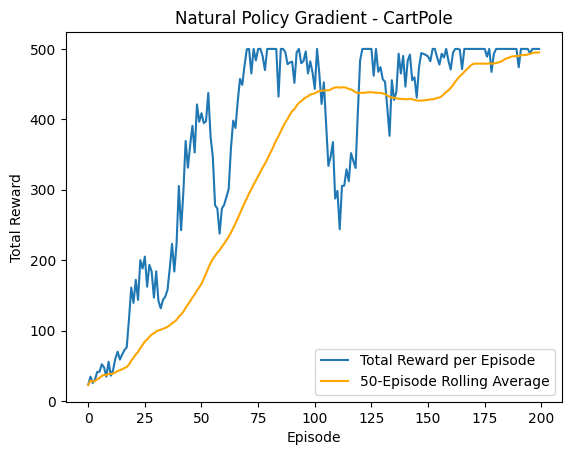

In [141]:
# Calculate the recent 50-episode interval average
window_size = 50
rolling_avg = [np.mean(total_rewards[max(0, i-window_size):(i+1)]) for i in range(len(total_rewards))]

# Plot the total rewards and rolling average over episodes
plt.plot(total_rewards, label='Total Reward per Episode')
plt.plot(rolling_avg, label=f'{window_size}-Episode Rolling Average', color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Natural Policy Gradient - CartPole')
plt.legend()
plt.show()
